In [3]:
import pandas as pd
import numpy as np
import missingno as msn

## 1. CO2 data

In [4]:
environment_data = pd.read_csv('raw_data/environment_data.csv')

/var/folders/_j/dw2kb35j0ds2hc0km23ypls40000gn/T/ipykernel_7013/2313099627.py:1: DtypeWarning: Columns (114,115,116,117,118,119,120,123,128,130,131,134,135,136,140,141,142) have mixed types. Specify dtype option on import or set low_memory=False.
  environment_data = pd.read_csv('raw_data/environment_data.csv')


In [5]:
# identifier on gvkey and time is fiscal year to merge with financial data,
col = ['gvkey', 'fiscalyear', 'simpleindustry', 'di_319407', 'di_319408', 'di_319409', 'di_319522', 'yearfounded']
co2_data = environment_data[col].copy()
co2_data.columns = ['gvkey', 'fyear', 'industry', 'Intensity_scope1', 'Intensity_scope2', 'Intensity_scope3', 'revenue', 'yearfounded']

co2_data['Co2_scope1'] = co2_data.Intensity_scope1 * co2_data.revenue
co2_data['Co2_scope2'] = co2_data.Intensity_scope2 * co2_data.revenue
co2_data['Co2_scope3'] = co2_data.Intensity_scope3 * co2_data.revenue

# co2 total
co2_data['Co2_tot'] = co2_data.Co2_scope1.fillna(0) + co2_data.Co2_scope2.fillna(0) + co2_data.Co2_scope3.fillna(0)
co2_data['Intensity_tot'] = co2_data.Intensity_scope1.fillna(0) + co2_data.Intensity_scope2.fillna(0) + co2_data.Intensity_scope3.fillna(0)

# drop if gvkey is missing
co2_data.dropna(subset='gvkey', inplace=True)

# sort by values
co2_data.sort_values(['gvkey', 'fyear'], inplace=True)

# sales growth
co2_data['SaleGR'] = co2_data.groupby('gvkey')['revenue'].pct_change()

# sort index
co2_data.reset_index(drop=True, inplace=True)

In [6]:
# cut firms into green and brown based on each years carbon emission
co2_data['greenness_co2'] = co2_data.groupby('fyear')['Co2_tot'].transform(lambda x: pd.qcut(x, q=5, labels=range(1,6)))
co2_data['greenness_int'] = co2_data.groupby('fyear')['Intensity_tot'].transform(lambda x: pd.qcut(x, q=5, labels=range(1,6)))

In [7]:
# cut firms into green and brown based on each years carbon emission within industry
def custom_qcut(series):
    # Check if the group has at least 3 unique observations
    if series.nunique() >= 5:
        try:
            # Attempt to apply pd.qcut
            return pd.qcut(series, q=5, labels=range(1, 6), duplicates='drop')
        except ValueError:
            # If pd.qcut fails, assign np.nan to the entire group
            return pd.Series([np.nan] * len(series), index=series.index)
    else:
        # For groups with less than 5 unique observations, assign np.nan
        return pd.Series([np.nan] * len(series), index=series.index)

# Apply the custom function using transform
co2_data['greenness_co2_industry'] = co2_data.groupby(['fyear', 'industry'])['Co2_tot'].transform(custom_qcut)
co2_data['greenness_int_industry'] = co2_data.groupby(['fyear', 'industry'])['Intensity_tot'].transform(custom_qcut)

## 2. Financial data

In [8]:
finance_data = pd.read_csv('raw_data/finance_data.csv')

/var/folders/_j/dw2kb35j0ds2hc0km23ypls40000gn/T/ipykernel_7013/3450532343.py:1: DtypeWarning: Columns (10,12,16,17,26,30,33,34,35,945,946,948,949,950,955,969,970,975,980) have mixed types. Specify dtype option on import or set low_memory=False.
  finance_data = pd.read_csv('raw_data/finance_data.csv')


In [9]:
col = ['gvkey', 'fyear', 'at', 'ppegt', 'emp', 'cogs', 'capx', 'lt', 'sale', 'csho', 'ceq', 'ib', 'epspx', 'ni', 'xint', 'dp', 'txt']
finance_data_reduced = finance_data[col].copy()

# all are in millions of dollars

# at: Assets - Total
# ppegt: Property, Plant and Equipment - Total (Gross)
# emp: number of employees
# cogs: Cost of Goods Sold
# capx: Capital Expenditures
# lt: Liabilities - Total
# sale: Sales/Turnover Net, revenue
# csho: common share outstanding in thousands
# ceq: Common/Ordinary Equity - Total
# ib: Income Before Extraordinary Items
# epspx: Earnings Per Share (Basic)/Excluding Extraordinary Items
# ni: Net Income (Loss)
# xint: Interest and Related Expense - Total
# dp: Depreciation and Amortization
# txt: Income Taxes - Total

# there are duplicates for the same gvkey and fyear, lets keep the one with the most complete columns and drop the others

# Step 1: Sort the DataFrame
# Count non-NA values across columns other than 'gvkey' and 'fyear'
finance_data_reduced['non_na_count'] = finance_data_reduced.drop(columns=['gvkey', 'fyear']).notna().sum(axis=1)
finance_data_reduced = finance_data_reduced.sort_values(by=['gvkey', 'fyear', 'non_na_count'], ascending=[True, True, False])

# Step 2: Drop duplicates
finance_data_reduced = finance_data_reduced.drop_duplicates(subset=['gvkey', 'fyear'])

# drop the helper column
finance_data_reduced = finance_data_reduced.drop(columns=['non_na_count'])

# Now dataset contains only one row per ['gvkey', 'fyear'] pair, prioritizing rows with the most complete data

## 3. Merge CO2 and Finance data

In [10]:
# merged on gvkey and fyear
co2_finance = pd.merge(co2_data, finance_data_reduced, how='left', indicator='left_only')

In [11]:
co2_finance.groupby('left_only').gvkey.nunique()

/var/folders/_j/dw2kb35j0ds2hc0km23ypls40000gn/T/ipykernel_7013/1366444434.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  co2_finance.groupby('left_only').gvkey.nunique()


left_only
left_only     17837
right_only        0
both           5878
Name: gvkey, dtype: int64

## 4. Stock data

In [12]:
# load monthly price data from CRSP
stock_data = pd.read_csv('raw_data/monthly_stock_CRSP.csv')

# convert date to year_month format
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data['year_month'] = stock_data['date'].dt.to_period('M')

# choose data from date since 2002
stock_data = stock_data[stock_data.year_month > '2001-12']
stock_data = stock_data.sort_values(['PERMNO', 'year_month']).reset_index(drop=True)

# replace missing return with nan
stock_data['RET'] = stock_data['RET'].replace({'C': np.nan, 'B': np.nan})
stock_data['RET'] = stock_data['RET'].astype(float)
stock_data['PRC'] = np.abs(stock_data.PRC)

# select variables 
stock_data = stock_data[['PERMNO', 'year_month', 'RET', 'PRC']]

## 5. Merge stock data

In [13]:
link_table = pd.read_csv('raw_data/link_table.csv')

link_table = link_table[['gvkey', 'LPERMNO']]
link_table.columns = ['gvkey', 'PERMNO']

/var/folders/_j/dw2kb35j0ds2hc0km23ypls40000gn/T/ipykernel_7013/3502088752.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  link_table = pd.read_csv('raw_data/link_table.csv')


In [14]:
# merge link table to stock price data on Permno
stock_data = stock_data.merge(link_table, how='left')

# merge stock data with co2_finance data on GVKEY and year
stock_data['year'] = stock_data.year_month.dt.year
data = stock_data.merge(co2_finance, left_on=['gvkey', 'year'], right_on=['gvkey', 'fyear'], how='left')

In [15]:
data = data.dropna(subset=['PERMNO', 'Intensity_tot', 'RET'], how='any')

In [16]:
# sort data
data = data.sort_values(['PERMNO', 'year_month'])

# Construct control variables
# 1. size (log later)
data['Marketcap'] = data.csho * data.PRC
# 2. Leverage
data['Levarage'] = data['lt'] / data['at']
# 3. B/M book to market ratio
data['B/M'] = data.ceq / data.Marketcap
# 4. RoE
data['RoE'] = data.ni / data.ceq
# 5. Investment/total asset
data['Inves/AT'] = data.capx / data['at']
# 6. PPE (log later)
data['PPE'] = data.ppegt
# 7. SaleGR
data['SaleGR'] = data.SaleGR
# 8. EPS
data['EPS'] = data.epspx
# 9. Stuff_num (log later)
data['Staff_num'] = data.emp
# 10. Firm_age (log later)
data['Firm_age'] = 2023 - data.yearfounded

In [17]:
# construct dependent variables
# 1. RoE
# 2. RoA
data['RoA'] = data.ni / data['at']
# 3. RoS
data['RoS'] = data.ni / data.revenue
# 4. EBITMrgpct
data['EBITMrgpct'] = (data.ni.fillna(0) + data.xint.fillna(0) + data.txt.fillna(0)) / data['revenue']
# 5. EBITDAMrgpct
data['EBITDAMrgpct'] = (data.ni.fillna(0) + data.xint.fillna(0) + data.txt.fillna(0) + data.dp.fillna(0)) / data['revenue']

In [18]:
data = data[['PERMNO', 'year_month', 'year', 'industry', 'RET', 'Co2_tot', 'Intensity_tot', 'Co2_scope1', 'Co2_scope2', 'Co2_scope3', 'Intensity_scope1', 'Intensity_scope2', 'Intensity_scope3', 'Marketcap', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age', 'RoA', 'RoS', 'EBITMrgpct', 'EBITDAMrgpct', 'greenness_co2', 'greenness_int', 'greenness_co2_industry', 'greenness_int_industry']]

<Axes: >

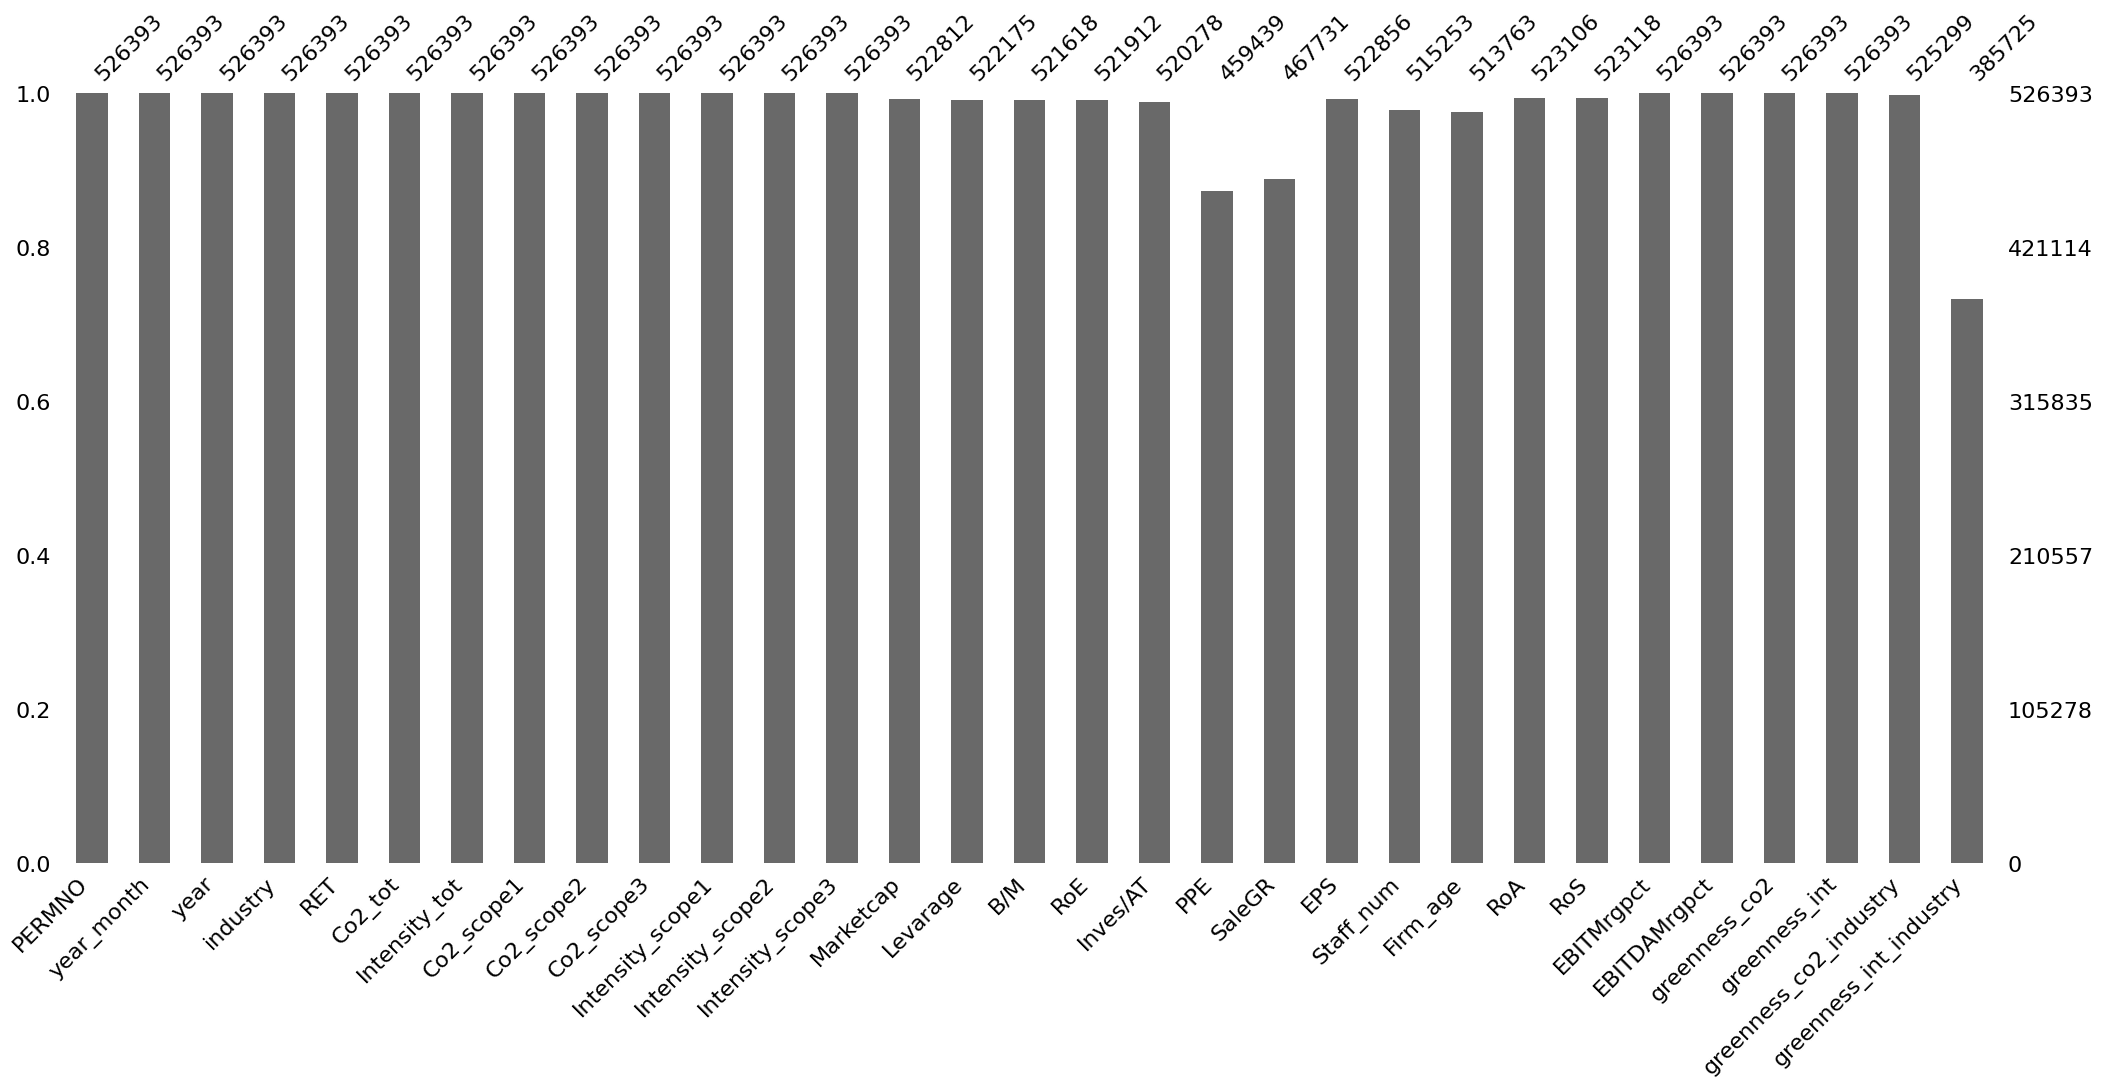

In [19]:
msn.bar(data)

In [20]:
# replace invalid values with nas
data = data.replace([np.inf, -np.inf], np.nan)

In [21]:
# save data to later use
data.to_csv('data.csv', index=False)

## 6. Data exploring

In [22]:
data = pd.read_csv('data.csv')

In [23]:
data.Co2_tot.mean()

5427269.051145981

In [24]:
data.Co2_tot.min()

0.2677972

In [25]:
data.Co2_tot.describe()

count    5.263930e+05
mean     5.427269e+06
std      2.171045e+07
min      2.677972e-01
25%      6.589816e+04
50%      4.018736e+05
75%      2.002266e+06
max      4.144484e+08
Name: Co2_tot, dtype: float64

In [26]:
num_companies = data.PERMNO.nunique()
num_obs = data.shape[0]
print('The number of companies is %d' %num_companies)
print('The number of observations is %d' %num_obs)
co2_min = data.Co2_tot.min()
co2_max = data.Co2_tot.max()
co2_mean = data.Co2_tot.mean()
print('Co2 min is %f,'% co2_min, 'Co2 max is %d,'% co2_max, 'Co2_mean is %d'%co2_mean)

The number of companies is 5250
The number of observations is 526393
Co2 min is 0.267797, Co2 max is 414448413, Co2_mean is 5427269


In [27]:
data['RET'] = data['RET']*100

data['Co2_tot'] = np.log(data.Co2_tot + 1)
data['Co2_scope1'] = np.log(data.Co2_scope1 + 1)
data['Co2_scope2'] = np.log(data.Co2_scope2 + 1)
data['Co2_scope3'] = np.log(data.Co2_scope3 + 1)

data['Intensity_tot'] = np.log(data.Intensity_tot + 1)
data['Intensity_scope1'] = np.log(data.Intensity_scope1 + 1)
data['Intensity_scope2'] = np.log(data.Intensity_scope2 + 1)
data['Intensity_scope3'] = np.log(data.Intensity_scope3 + 1)

data['Size'] = np.log(data.Marketcap + 1)
data['PPE'] = np.log(data.PPE + 1)
data['Staff_num'] = np.log(data.Staff_num + 1)
data['Firm_age'] = np.log(data.Firm_age + 1)

### 6.1 Dependent data

In [28]:
np.round(data[['RET', 'RoE', 'RoA', 'RoS', 'EBITMrgpct', 'EBITDAMrgpct']].describe(), 3)

,RET,RoE,RoA,RoS,EBITMrgpct,EBITDAMrgpct
count,526393.000,521900.000,523106.000,523118.000,526393.000,526393.000
mean,1.304,-1.377,0.010,-4.083,-3.871,-3.676
std,14.700,215.974,0.200,122.633,122.765,121.518
min,-92.056,-31837.000,-13.717,-15843.182,-15826.818,-15592.727
25%,-4.736,0.018,0.004,0.010,0.035,0.078
50%,0.979,0.101,0.032,0.069,0.118,0.175
75%,6.595,0.183,0.073,0.148,0.233,0.319
max,1625.053,388.700,5.582,2024.422,2770.653,3367.797


In [29]:
# there are extrem values in some variables hence we winsorize the data
two_way_winsorize = ['RoE', 'RoA', 'RoS', 'EBITMrgpct', 'EBITDAMrgpct']
quantiles = data.quantile([0.01, 0.99], numeric_only=True) # calculate quantiles for each column
for col in two_way_winsorize:
  data.loc[(data[col] < quantiles[col].loc[0.01]) | (data[col] > quantiles[col].loc[0.99]), col] = np.nan # replace outliers with np.nan

In [30]:
# summary statistics after winsorizing
np.round(data[['RET', 'RoE', 'RoA', 'RoS', 'EBITMrgpct', 'EBITDAMrgpct']].describe(), 3)

,RET,RoE,RoA,RoS,EBITMrgpct,EBITDAMrgpct
count,526393.000,511472.000,512648.000,512666.000,515870.000,515873.000
mean,1.304,0.064,0.019,-0.086,-0.013,0.062
std,14.700,0.397,0.116,1.110,1.085,1.053
min,-92.056,-3.195,-0.722,-18.075,-17.391,-16.557
25%,-4.736,0.020,0.005,0.011,0.037,0.080
50%,0.979,0.101,0.032,0.069,0.118,0.175
75%,6.595,0.181,0.072,0.146,0.229,0.315
max,1625.053,2.768,0.279,0.630,1.055,1.151


### 6.2 CO2 emission data

In [31]:
np.round(data[['Co2_tot', 'Intensity_tot', 'Co2_scope1', 'Co2_scope2', 'Co2_scope3', 'Intensity_scope1', 'Intensity_scope2', 'Intensity_scope3']].describe(), 3)

,Co2_tot,Intensity_tot,Co2_scope1,Co2_scope2,Co2_scope3,Intensity_scope1,Intensity_scope2,Intensity_scope3
count,526393.000,526393.000,526393.000,526393.000,526393.000,526393.000,526393.000,526393.000
mean,12.751,5.184,10.409,10.383,12.173,3.059,2.937,4.611
std,2.664,1.264,3.232,2.573,2.522,2.009,1.209,0.972
min,0.237,3.065,0.000,0.000,0.175,0.000,0.000,2.968
25%,11.096,4.221,8.295,8.883,10.561,1.654,2.190,3.785
50%,12.904,5.006,10.321,10.563,12.361,2.747,2.935,4.548
75%,14.510,5.989,12.464,12.100,13.912,3.864,3.757,5.396
max,19.842,11.407,19.782,18.979,19.251,10.360,11.406,8.817


### 6.3 Control variables

In [32]:
np.round(data[['Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].describe(), 3)

,Size,Levarage,B/M,RoE,Inves/AT,PPE,SaleGR,EPS,Staff_num,Firm_age
count,522812.000,522175.000,521618.000,511472.000,520278.000,459439.000,467731.000,522856.000,515253.000,513763.000
mean,8.209,0.611,5.207,0.064,0.041,7.073,1.746,5.749,2.111,3.988
std,1.809,0.267,937.080,0.397,0.053,2.422,96.706,151.895,1.487,0.790
min,0.008,0.001,-4127.450,-3.195,-0.186,0.000,-1.000,-998.260,0.000,1.099
25%,7.073,0.445,0.233,0.020,0.008,5.627,-0.023,0.130,0.821,3.401
50%,8.207,0.606,0.436,0.101,0.025,7.256,0.063,1.440,1.960,4.007
75%,9.399,0.770,0.727,0.181,0.055,8.781,0.176,3.050,3.172,4.673
max,20.722,6.925,274698.311,2.768,0.869,13.362,9944.997,8548.000,7.741,6.489


In [33]:
two_way_winsorize = ['B/M', 'SaleGR', 'EPS']
quantiles = data.quantile([0.01, 0.99], numeric_only=True) # calculate quantiles for each column
for col in two_way_winsorize:
  data.loc[(data[col] < quantiles[col].loc[0.01]) | (data[col] > quantiles[col].loc[0.99]), col] = np.nan # replace outliers with np.nan

In [34]:
np.round(data[['Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].describe(), 3)

,Size,Levarage,B/M,RoE,Inves/AT,PPE,SaleGR,EPS,Staff_num,Firm_age
count,522812.000,522175.000,511184.000,511472.000,520278.000,459439.000,458396.000,512453.000,515253.000,513763.000
mean,8.209,0.611,0.529,0.064,0.041,7.073,0.104,1.745,2.111,3.988
std,1.809,0.267,0.431,0.397,0.053,2.422,0.290,3.023,1.487,0.790
min,0.008,0.001,-0.537,-3.195,-0.186,0.000,-0.636,-9.780,0.000,1.099
25%,7.073,0.445,0.237,0.020,0.008,5.627,-0.021,0.150,0.821,3.401
50%,8.207,0.606,0.436,0.101,0.025,7.256,0.063,1.440,1.960,4.007
75%,9.399,0.770,0.719,0.181,0.055,8.781,0.172,3.010,3.172,4.673
max,20.722,6.925,3.006,2.768,0.869,13.362,2.597,18.270,7.741,6.489


In [36]:
# output summary statistic table
np.round(data[['RET', 'Co2_tot', 'Intensity_tot', 'Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']].describe(), 3).T[['count','mean', 'std', 'min', '50%', 'max']].to_latex('summary_statistics.tex', float_format="{:.3f}".format)

In [37]:
# compute the pearson corr among each variables, with statistic significance

# define a function to compute the correlation 
from scipy.stats import pearsonr
def correlation_(df):
  rho = df.corr()
  pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
  tab = rho.round(2).astype(str) + p
  for i in range(0,tab.shape[1]):
    for j in range(0,tab.shape[1]):
      if i>j:
        tab.iloc[i,j] = ''
  return tab

tab = correlation_(data[['Co2_tot', 'Intensity_tot', 'Size', 'Levarage', 'B/M', 'RoE', 'Inves/AT', 'PPE', 'SaleGR', 'EPS', 'Staff_num', 'Firm_age']])
tab.style.to_latex('corr.tex')
tab

/var/folders/_j/dw2kb35j0ds2hc0km23ypls40000gn/T/ipykernel_7013/1720778294.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))


,Co2_tot,Intensity_tot,Size,Levarage,B/M,RoE,Inves/AT,PPE,SaleGR,EPS,Staff_num,Firm_age
Co2_tot,1.0***,0.63***,0.66***,0.09***,0.02***,0.22***,0.24***,0.85***,-0.1***,0.3***,0.72***,0.38***
Intensity_tot,,1.0***,0.08***,-0.13***,-0.0**,0.01***,0.37***,0.44***,-0.04***,-0.0,0.13***,0.1***
Size,,,1.0***,0.02***,-0.21***,0.23***,0.05***,0.68***,0.01***,0.39***,0.69***,0.3***
Levarage,,,,1.0***,-0.06***,0.06***,-0.08***,0.18***,-0.09***,0.03***,0.15***,0.2***
B/M,,,,,1.0***,-0.09***,-0.04***,0.11***,-0.12***,-0.06***,-0.05***,0.04***
RoE,,,,,,1.0***,0.03***,0.18***,0.03***,0.39***,0.19***,0.17***
Inves/AT,,,,,,,1.0***,0.33***,0.07***,0.01***,0.05***,-0.04***
PPE,,,,,,,,1.0***,-0.13***,0.27***,0.71***,0.39***
SaleGR,,,,,,,,,1.0***,0.05***,-0.11***,-0.16***
EPS,,,,,,,,,,1.0***,0.29***,0.25***


In [38]:
# save winsorized data
data.to_csv('data_win.csv', index=False)